         Date   Time Road_Condition Weather_Condition   Latitude   Longitude  \
0  2023-11-24  03:05          Snowy             Foggy  28.755148  130.981229   
1  2023-02-27  12:06            Wet             Clear  80.432762 -160.498373   
2  2023-01-13  11:54            Icy             Foggy -60.277147   55.243976   
3  2023-05-21  11:38            Icy             Snowy   4.981282   52.624710   
4  2023-05-06  08:51            Icy             Rainy  19.186905 -158.179437   

   Severity  
0         2  
1         1  
2         5  
3         5  
4         1  
Dataset Head:
         Date   Time Road_Condition Weather_Condition   Latitude   Longitude  \
0  2023-11-24  03:05          Snowy             Foggy  28.755148  130.981229   
1  2023-02-27  12:06            Wet             Clear  80.432762 -160.498373   
2  2023-01-13  11:54            Icy             Foggy -60.277147   55.243976   
3  2023-05-21  11:38            Icy             Snowy   4.981282   52.624710   
4  2023-05-06  08:51 

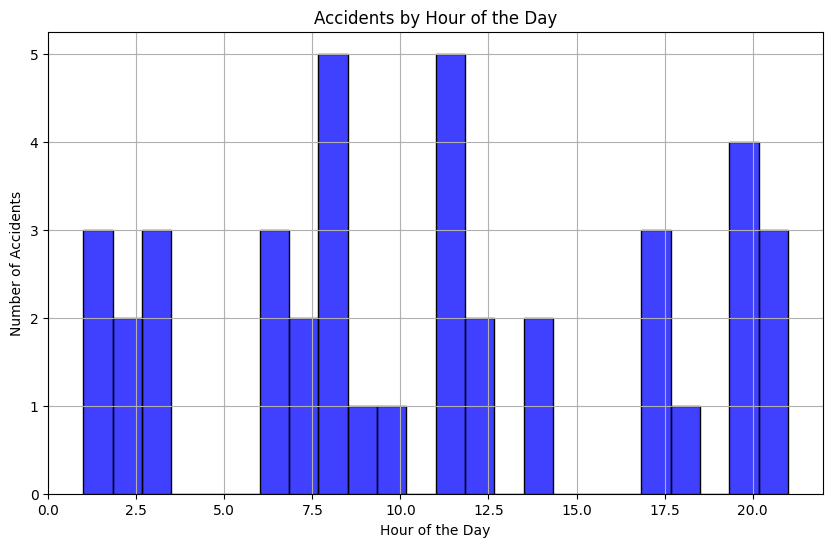

<ipython-input-17-a27acc7b96fc>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Road_Condition', palette='viridis', order=data['Road_Condition'].value_counts().index)


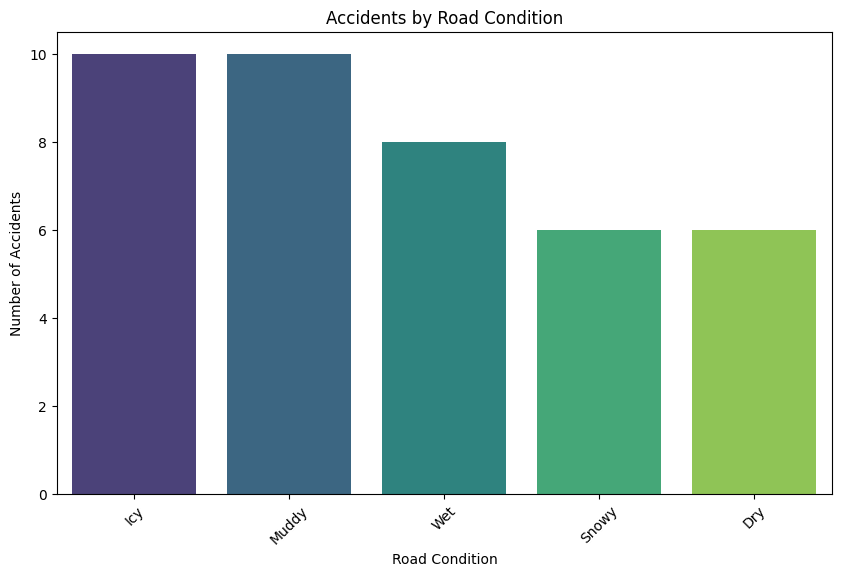

<ipython-input-17-a27acc7b96fc>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Weather_Condition', palette='coolwarm', order=data['Weather_Condition'].value_counts().index)


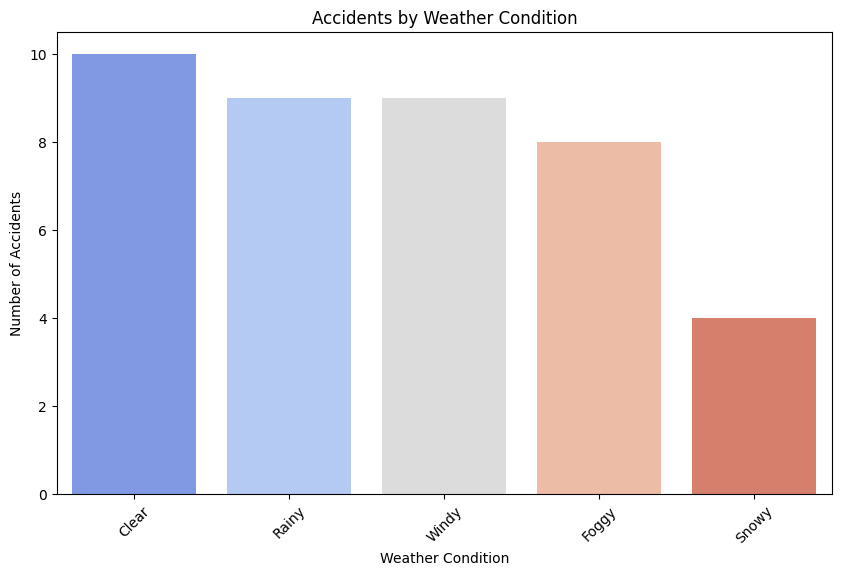

Accident Hotspots Map saved as 'Accident_Hotspots.html'


In [17]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Replace 'your_dataset.csv' with the actual file name or path
data = pd.read_csv('/content/synthetic_traffic_accidents.csv')

# Display the first few rows to verify it's loaded correctly
print(data.head())

# Convert Date and Time into a single datetime column
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data['Hour'] = data['DateTime'].dt.hour  # Extract the hour for time-of-day analysis

# Basic info and checks
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
print(data.info())

# ---- Plot 1: Accidents by Hour of the Day ----
plt.figure(figsize=(10, 6))
sns.histplot(data['Hour'], bins=24, kde=False, color='blue')
plt.title("Accidents by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Accidents")
plt.grid()
plt.show()

# ---- Plot 2: Accidents by Road Condition ----
if 'Road_Condition' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x='Road_Condition', palette='viridis', order=data['Road_Condition'].value_counts().index)
    plt.title("Accidents by Road Condition")
    plt.xlabel("Road Condition")
    plt.ylabel("Number of Accidents")
    plt.xticks(rotation=45)
    plt.show()

# ---- Plot 3: Accidents by Weather Condition ----
if 'Weather_Condition' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x='Weather_Condition', palette='coolwarm', order=data['Weather_Condition'].value_counts().index)
    plt.title("Accidents by Weather Condition")
    plt.xlabel("Weather Condition")
    plt.ylabel("Number of Accidents")
    plt.xticks(rotation=45)
    plt.show()

# ---- Heatmap: Accident Hotspots ----
if 'Latitude' in data.columns and 'Longitude' in data.columns:
    # Create a base map centered at the mean latitude and longitude
    center_lat = data['Latitude'].mean()
    center_lon = data['Longitude'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=2)

    # Add heatmap
    heat_data = data[['Latitude', 'Longitude']].dropna().values.tolist()
    HeatMap(heat_data).add_to(m)

    # Save and display the map
    m.save("Accident_Hotspots.html")
    print("Accident Hotspots Map saved as 'Accident_Hotspots.html'")


<ipython-input-23-3dc6ad44e74d>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap('tab10')(each) for each in np.linspace(0, 1, len(unique_labels))]


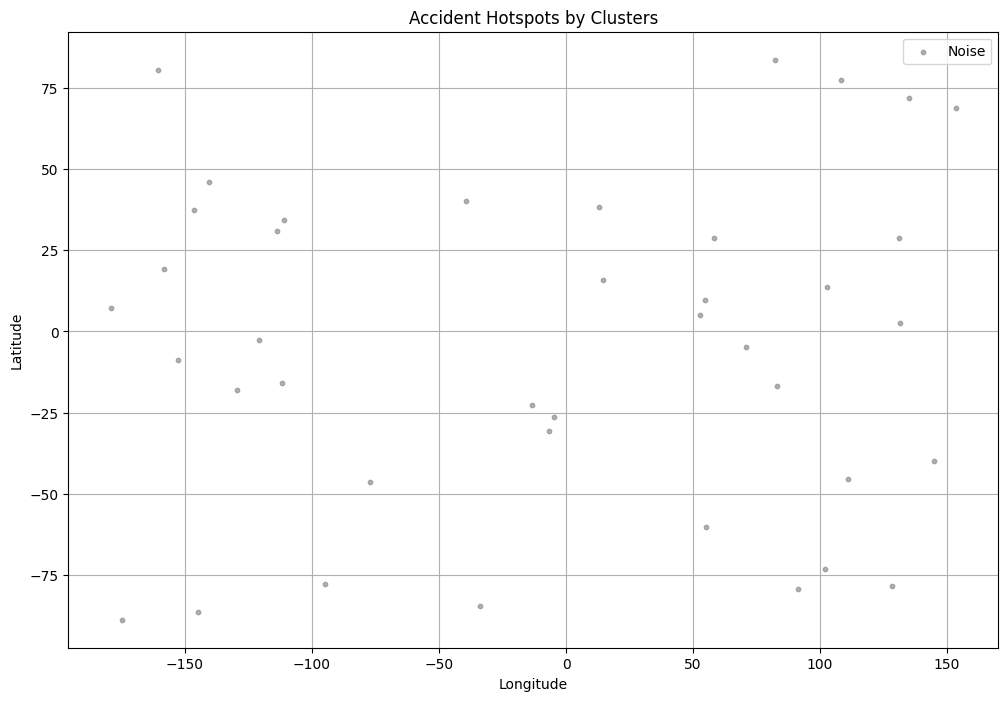

In [23]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

def visualize_hotspots_with_graphs(data, eps=0.5, min_samples=3):
    """
    Identifies accident hotspots using DBSCAN clustering and visualizes them in a scatter plot.

    Parameters:
        data (DataFrame): The accident data containing Latitude and Longitude.
        eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood.
        min_samples (int): The number of samples in a neighborhood for a point to be considered a core point.
    """
    # Check if Latitude and Longitude columns exist
    if 'Latitude' not in data.columns or 'Longitude' not in data.columns:
        print("Latitude and Longitude columns are required.")
        return

    # Prepare data for clustering
    coords = data[['Latitude', 'Longitude']].dropna().values

    # Apply DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine').fit(np.radians(coords))
    labels = db.labels_

    # Add cluster labels to the dataset
    data['Cluster'] = -1
    data.loc[data[['Latitude', 'Longitude']].dropna().index, 'Cluster'] = labels

    # Visualize clusters
    plt.figure(figsize=(12, 8))
    unique_labels = set(labels)
    colors = [plt.cm.get_cmap('tab10')(each) for each in np.linspace(0, 1, len(unique_labels))]

    for label, color in zip(unique_labels, colors):
        if label == -1:
            # Noise points
            plt.scatter(
                data[data['Cluster'] == label]['Longitude'],
                data[data['Cluster'] == label]['Latitude'],
                c='grey',
                s=10,
                label='Noise',
                alpha=0.6
            )
        else:
            # Cluster points
            plt.scatter(
                data[data['Cluster'] == label]['Longitude'],
                data[data['Cluster'] == label]['Latitude'],
                s=20,
                label=f'Cluster {label}',
                alpha=0.7
            )

    plt.title('Accident Hotspots by Clusters')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Apply the function and visualize
eps_km = 50 / 6371.0  # Convert 50 km to radians (Earth radius = 6371 km)
min_accidents_per_hotspot = 3

visualize_hotspots_with_graphs(data, eps=eps_km, min_samples=min_accidents_per_hotspot)
